# CNN visualization of intermediate steps

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers
import tensorflow as tf
import seaborn as sns
# import pandas as pd

In [2]:
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Data

In [3]:
(xTrain, yTrain),(xTest, yTest) = datasets.mnist.load_data()
xTrain = xTrain / 255.
xTest  = xTest  / 255.

xTrainPad  = np.pad(xTrain.reshape(-1, 28, 28, 1), ((0,0),(2,2),(2,2),(0,0)), 'constant')
xTestPad   = np.pad(xTest.reshape(-1, 28, 28, 1), ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Model

In [4]:
modelLeNet60 = models.load_model('models/MNIST_LeNet60.h5')
modelLeNet60.summary()

Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_248 (Avera (None, 15, 15, 6)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_249 (Avera (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 576)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 60)             

# Helpers

In [5]:
def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)

def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotOutputs(numConvo, numCols, samples, originals):
    """ Plot a layer output on selected samples """
    numRowsPerSample = int(np.ceil(numConvo / numCols))
    numRows = len(originals) * numRowsPerSample
    fig, axes = plt.subplots(numRows, numCols + 1, figsize=((numCols + 1) * 2, numRows * 2))
    axes = axes.ravel()
    for i, sample in enumerate(samples):
        ax = axes[i * (numRowsPerSample * (numCols + 1))]
        ax.imshow(originals[i], cmap='gray')
        if(i == 0): 
            ax.xaxis.tick_top()
            ax.set_xlabel('original')
        for row in range(numRowsPerSample):
            for col in range(numCols):
                c = row * numCols + col
                ax = axes[(i * numRowsPerSample + row) * (numCols + 1) + col + 1]
                ax.imshow(samples[i,:, :, c], cmap='gray')
                if(i == 0): 
                    ax.xaxis.tick_top()
                    ax.set_xlabel('Conv #' + str(c))
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)

# Convolution layer #0 activation

Convolution layer #0 is connected to the 32x32, single channel image input. There are 6 convolutions in this layer.

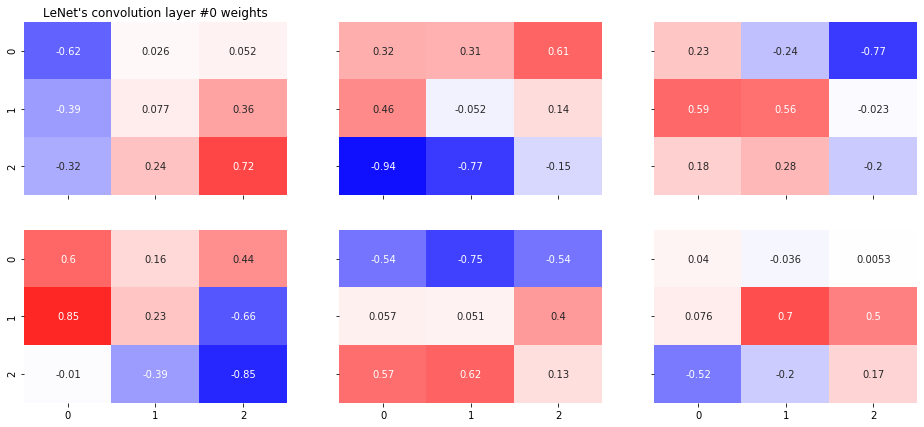

In [6]:
weightsLeNet60 = modelLeNet60.get_weights()

fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(weightsLeNet60[0][:,:, 0, i], [0, 1, 2], ax=ax, vmin=-1., vmax=1., cbar=False)

axes[0,0].set_title("LeNet's convolution layer #0 weights");

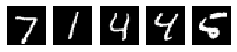

In [7]:
selectedSampleIndexes = [0,2,4,6,8]
fig, axes = plt.subplots(1, len(selectedSampleIndexes), figsize=(4, 2))
for ax, i in zip(axes, selectedSampleIndexes):
    ax.imshow(xTest[i], cmap='gray')
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

In [8]:
sampleAtLayer0 = predictUntilLayer(modelLeNet60, 0, xTestPad[selectedSampleIndexes])
sampleAtLayer0.shape

(5, 30, 30, 6)

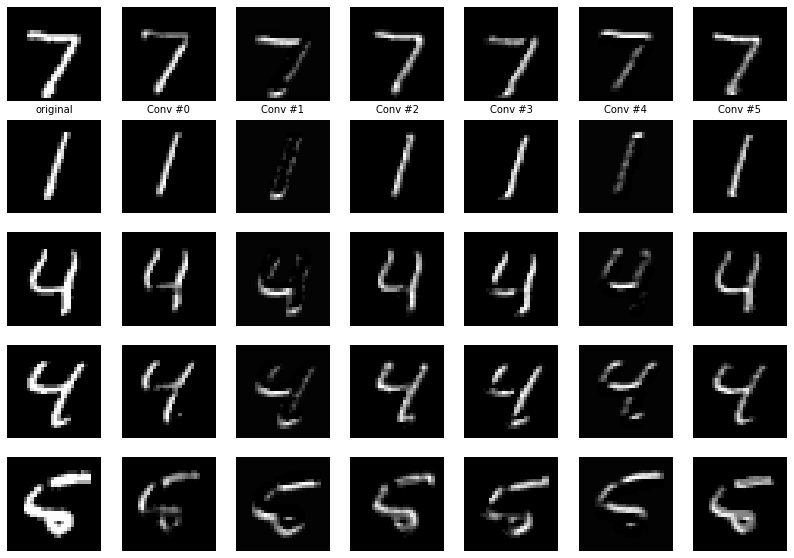

In [9]:
plotOutputs(6, 6, sampleAtLayer0, xTest[selectedSampleIndexes])

We may observe that:
- convolutions #0 and #2 are close to identity
- convolution #1 is acting as an horizontal edge detector and partially as vertical detector
- convolution #3 is acting as an horizontal edge detector from the right direction
- convolutions #4 and #5 are like smoothing / blur filters

## Layer #0 dropout activations

In [10]:
sampleAtLayer0drop = predictUntilLayer(modelLeNet60, 1, xTestPad[selectedSampleIndexes])
sampleAtLayer0drop.shape

(5, 15, 15, 6)

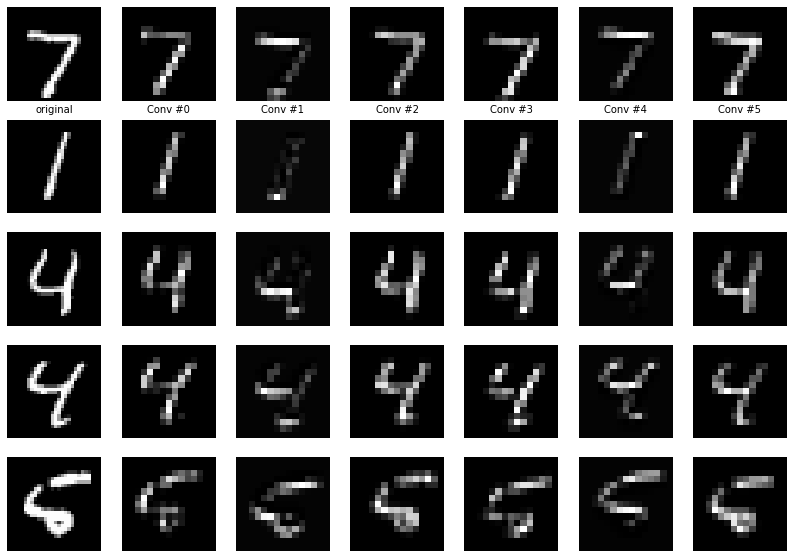

In [11]:
plotOutputs(6, 6, sampleAtLayer0drop, xTest[selectedSampleIndexes])

As expected, the average drop out is acting as a low pass filter and a downsampler.

# Convolution layer #1 activation

Convolution layer #1 is connecter to the #0 by an average pooling 2x2 (halving the size of the image on each of the 2 dimensions). It is made of 16 convolutions connected to each of the 6 inputs.

In [12]:
weightsLeNet60[2].shape

(3, 3, 6, 16)

In [13]:
sampleAtLayer1 = predictUntilLayer(modelLeNet60, 2, xTestPad[selectedSampleIndexes])
sampleAtLayer1.shape

(5, 13, 13, 16)

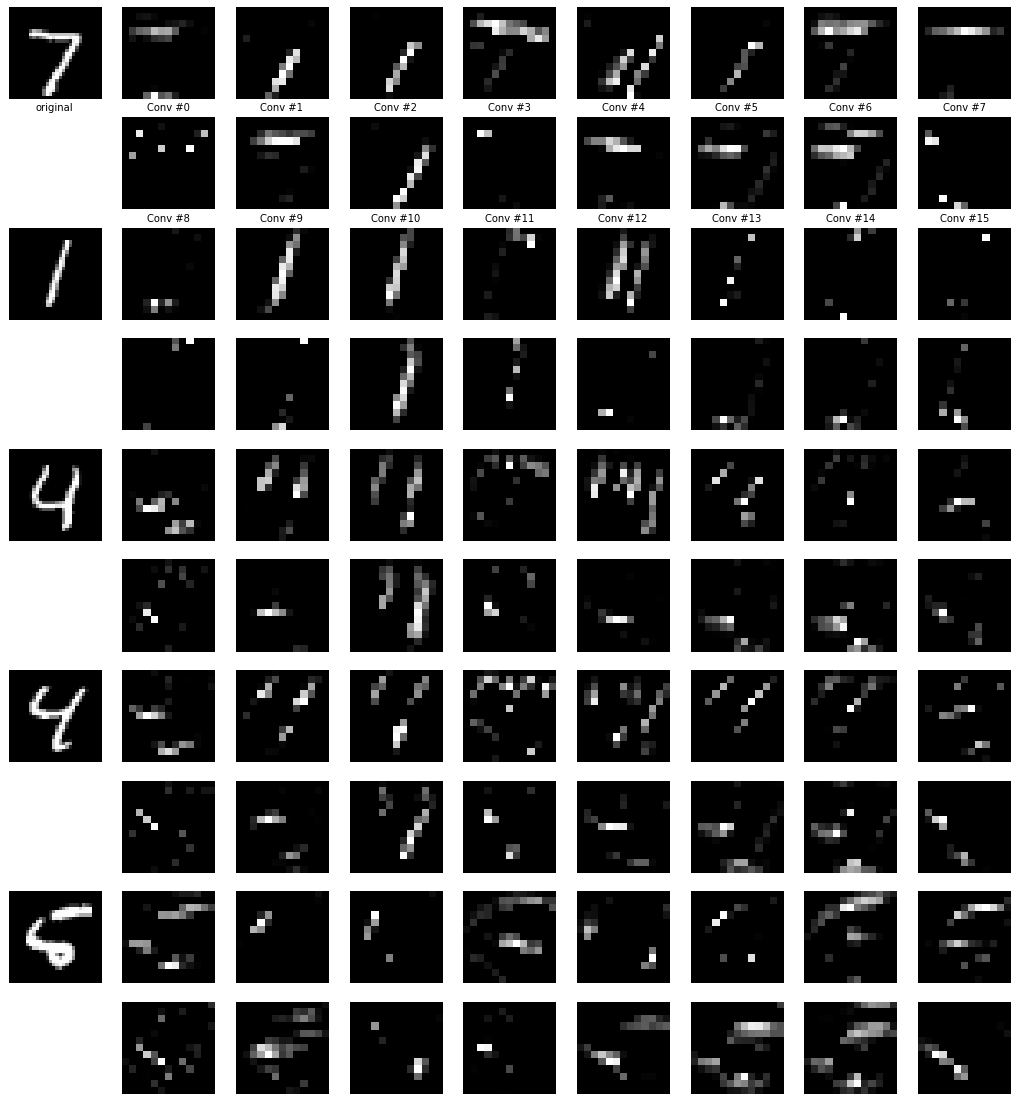

In [14]:
plotOutputs(16, 8, sampleAtLayer1, xTest[selectedSampleIndexes])

We see that at the output of the second convolutional layer, the filters are focusing on some more detailed par of the digits. But it is becomes harder to exactly state what is the focus of each filter.

# Saliency maps

In [137]:
modelToC0 = models.Model(inputs=modelLeNet60.input,
                      outputs=modelLeNet60.layers[0].output)

modelToC1 = models.Model(inputs=modelLeNet60.input,
                      outputs=modelLeNet60.layers[2].output)

@tf.function
def gradLoss(model, img):
    with tf.GradientTape() as tape:
        tape.watch(img)
        activation = model(img)
        loss = tf.math.reduce_mean(activation)
    return loss, tape.gradient(loss, img)

@tf.function
def getSalient(numEpochs, model, img, step_size=0.01):
    
    imgTf = tf.expand_dims(img, axis=0)
    #optimizer = optimizers.Adam()
    lossHist, gradHist = [], []
    
    for epoch in range(numEpochs):
       
        loss, grads = gradLoss(model, imgTf)
        
        # Gradient ascent
        #optimizer.apply_gradients(zip(grads, imgTf))
        imgTf = imgTf + grads * step_size
        
        lossHist.append(loss)
        gradHist.append(grads)
        #print("Epoch {}: loss = {}, grads = {}".format(epoch, lossValue, grads))
    
    return tf.clip_by_value(imgTf, 0, 1)[0], losses, gradHist

testImgIndex = 6
imgToC0, lossesToC0, gradsToC0 = getSalient(1000, modelToC0, xTestPad[testImgIndex], 0.5)
imgToC1, lossesToC1, gradsToC1 = getSalient(1000, modelToC1, xTestPad[testImgIndex], 0.5)

Text(0.5, 1.0, 'Salient * Input')

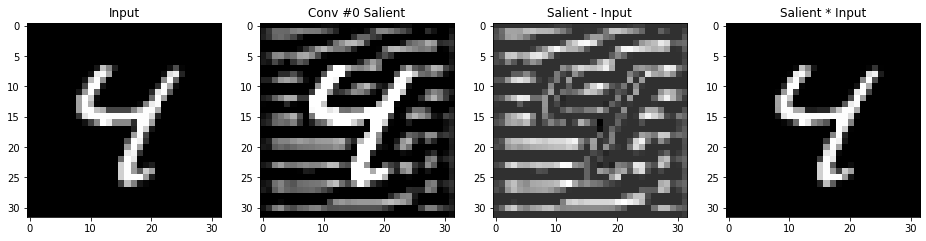

In [143]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(xTestPad[testImgIndex].reshape(32, 32), cmap='gray')
axes[0].set_title("Input")
axes[1].imshow(imgToC0.numpy().reshape(32, 32), cmap='gray')
axes[1].set_title("Conv #0 Salient")
axes[2].imshow((imgToC0.numpy() - xTestPad[testImgIndex]).reshape(32, 32), cmap='gray')
axes[2].set_title("Salient - Input")
axes[3].imshow((imgToC0.numpy() * xTestPad[testImgIndex]).reshape(32, 32), cmap='gray')
axes[3].set_title("Salient * Input")

Text(0.5, 1.0, 'Salient * Input')

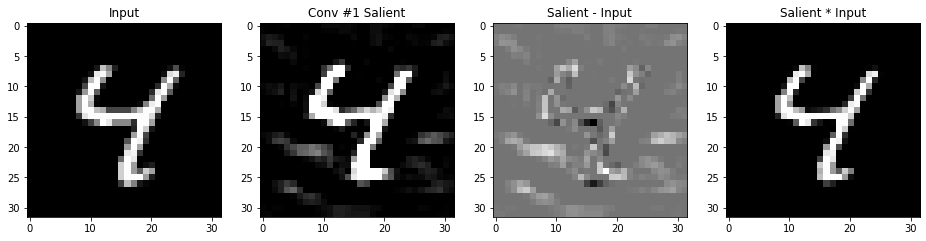

In [145]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(xTestPad[testImgIndex].reshape(32, 32), cmap='gray')
axes[0].set_title("Input")
axes[1].imshow(imgToC1.numpy().reshape(32, 32), cmap='gray')
axes[1].set_title("Conv #1 Salient")
axes[2].imshow((imgToC1.numpy() - xTestPad[testImgIndex]).reshape(32, 32), cmap='gray')
axes[2].set_title("Salient - Input")
axes[3].imshow((imgToC1.numpy() * xTestPad[testImgIndex]).reshape(32, 32), cmap='gray')
axes[3].set_title("Salient * Input")

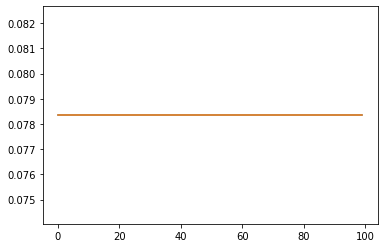

In [140]:
plt.plot(lossesToC0)
plt.plot(lossesToC1)

[None, None, None, None, None, None, None, None, None, None]

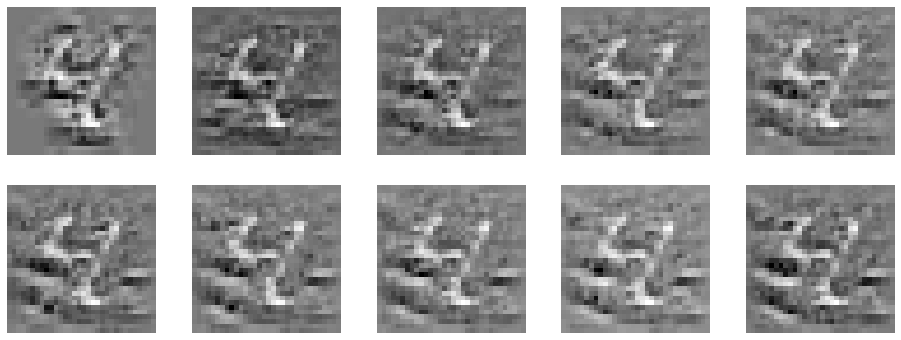

In [147]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(gradsToC1[100 * i].numpy().reshape(32, 32), cmap='gray')
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

https://www.tensorflow.org/tutorials/images/cnn